In [1]:
import torch

In [2]:
from transformers import CamembertTokenizer, CamembertModel, CamembertForSequenceClassification, Trainer, TrainingArguments

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from confmat import plot_confusion_matrix
import re
import os
import random
import numpy as np

In [4]:
model_dir = "models/tweetbert"
clusters_dir = "clusters/bert_clusters49_post_IF/"

### Chargement des données

In [9]:
dir_it = os.scandir(path=clusters_dir)  
filenames = [entry.name for entry in dir_it] 

In [10]:
raw_dataset = []

for filename in filenames:
    with open(clusters_dir + filename, "r") as f:
        lines = f.read().splitlines()
    lab = 0 if filename.split("_")[2] == "normal" else 1
    raw_dataset += [(msg, lab) for msg in lines]

In [11]:
# pour des résultats déterministes dans la phase d'évaluation
random.Random(0).shuffle(raw_dataset)

In [12]:
tweets = []
labels = []
for msg, lab in raw_dataset:
    tweets.append(msg)
    labels.append(lab)

### Charger le modèle

In [5]:
tokenizer = CamembertTokenizer.from_pretrained(model_dir, do_lowercase=False)
#classifier = CamembertForSequenceClassification.from_pretrained(model_dir)
#camembert = CamembertModel.from_pretrained(model_dir)
classifier = CamembertForSequenceClassification.from_pretrained("models/final_8020only_eq6448norm1M")

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
r = classifier.to(device)

In [13]:
# VIRER

In [13]:
nlist = []
hlist = []
for m, lab in zip(tweets, labels):
    if (lab == 1):
        hlist.append((m, 1))
    else:
        nlist.append((m, 0))

In [9]:
len(nlist)

5493

In [10]:
random.seed(0)
hsample = random.Random(0).sample(hlist, len(nlist))

In [11]:
balanced_dataset = hsample + nlist
random.Random(0)shuffle(balanced_dataset)

In [16]:
len(test_tweets) + len(train_tweets)

10986

In [17]:
len(balanced_dataset)

10986

In [13]:
btweets = []
blabels = []
for m, lab in balanced_dataset:
    btweets.append(m)
    blabels.append(lab)

### Fine tuning

In [15]:
train_tweets, test_tweets, train_labels, test_labels = train_test_split(tweets, labels, test_size=0.2, random_state=42)

In [12]:
train_encodings = tokenizer(train_tweets, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_tweets, padding=True, truncation=True, max_length=512, return_tensors="pt")

In [13]:
class FrTwitterHateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = FrTwitterHateDataset(train_encodings, train_labels)
test_dataset = FrTwitterHateDataset(test_encodings, test_labels)

In [16]:
training_args = TrainingArguments(
    output_dir='./models/final_model_80-20only_eq6448norm1M_chkpt',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    #per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    #evaluation_strategy="epoch"
)

#model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=classifier,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    #eval_dataset=test_dataset,             # evaluation dataset
    #compute_metrics=compute_metrics,
)

In [19]:
torch.cuda.empty_cache()

In [17]:
%%time
trainer.train()

/home/victor/data/fidle/fidle-env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 19105
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7167
/tmp/ipykernel_4558/823565030.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,0.680500
20,0.682500
30,0.668500
40,0.665700
50,0.655000
60,0.649500
70,0.650200
80,0.611700
90,0.580400
100,0.528500


Saving model checkpoint to ./models/final_model_80-20only_eq6448norm1M_chkpt/checkpoint-500
Configuration saved in ./models/final_model_80-20only_eq6448norm1M_chkpt/checkpoint-500/config.json
Model weights saved in ./models/final_model_80-20only_eq6448norm1M_chkpt/checkpoint-500/pytorch_model.bin
/tmp/ipykernel_4558/823565030.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Saving model checkpoint to ./models/final_model_80-20only_eq6448norm1M_chkpt/checkpoint-1000
Configuration saved in ./models/final_model_80-20only_eq6448norm1M_chkpt/checkpoint-1000/config.json
Model weights saved in ./models/final_model_80-20only_eq6448norm1M_chkpt/checkpoint-1000/pytorch_model.bin
/tmp/ipykernel_4558/823565030.py:7: UserWarning: To copy construct from a tensor, it is rec

CPU times: user 1h 22min 18s, sys: 4min 19s, total: 1h 26min 38s
Wall time: 1h 28min 43s


TrainOutput(global_step=7167, training_loss=0.11543985591891821, metrics={'train_runtime': 5323.37, 'train_samples_per_second': 10.767, 'train_steps_per_second': 1.346, 'total_flos': 5507811124605900.0, 'train_loss': 0.11543985591891821, 'epoch': 3.0})

In [16]:
%%time
test_pred = []
for n in range(0, len(test_tweets), 10):
    phrases = test_tweets[n:n+10]
    enc = tokenizer(phrases, padding=True, truncation=True, max_length=512, return_tensors='pt')
    enc.to('cuda:0')
    with torch.no_grad():
        outp = classifier(**enc)
    pred = torch.nn.functional.softmax(outp.logits, dim=1)
    plabels = torch.argmax(pred, dim=1)
    test_pred.append(plabels)

CPU times: user 41.4 s, sys: 10.1 ms, total: 41.4 s
Wall time: 41.5 s


In [17]:
cat_pred = torch.cat(test_pred)

In [15]:
r =classifier.to('cuda:0')

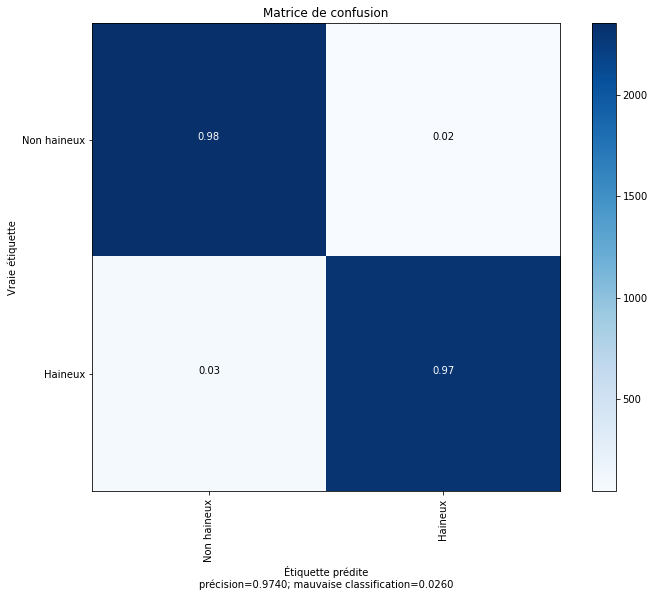

In [18]:
plot_confusion_matrix(test_labels, cat_pred.cpu(), ['Non haineux', 'Haineux'])

In [18]:
classifier.save_pretrained("models/final_8020only_eq6448norm1M")

Configuration saved in models/final_8020only_eq6448norm1M/config.json
Model weights saved in models/final_8020only_eq6448norm1M/pytorch_model.bin


In [115]:
start = 50
n = 20
for msg, lab in zip(test_tweets[start:start+n], cat_pred[start:start+n]):
    slab = "haineux" if lab == 1 else "normal"
    print("{} :\t{}".format(slab, msg))

normal :	S'opposer à l'immigration sans redresser notre natalité aura les mêmes effets qu'accepter le grand remplacement : en ce sens le RN est une illusion. Une part de remigration sera nécessaire : autant le dire et la négocier avec les pays d'origine.
haineux :	Espèce de grosse pute
normal :	Mdr, t'es bien gentil mais ta vidéo n'a aucun rapport 😂 elle parle des positions sur l'Histoire de Zemmour, qui sont sans aucun doute discutables. Ma vidéo parle de l'islamisation de territoires en France et de ses conséquences. Et cela ce n'est pas débunkable 😉
haineux :	Les kippa ne dehambule pas dans la rue pour tuer du kouffar, ils sont plus discret
normal :	En fait tu fais clairement un amalgame entre terroriste et musulman, c’est pour ça que je prend pas la peine de rentrer dans ton jeux car tu es toi-même perdu donc bon je vois pas le but de t’expliquer des choses que t’arrives pas à comprendre
haineux :	"Ah merci suis complètement d accord, elle est complètement hystérique cette femme"
h

### Test sur autre jeu de données

In [19]:
data_hate = pd.read_pickle("data_hate.pkl")
val_tweets = list(data_hate['tweet'])
val_labels = list(data_hate['sentiment'])

In [20]:
%%time
val_pred = []
for n in range(0, len(val_tweets), 10):
    phrases = val_tweets[n:n+10]
    enc = tokenizer(phrases, padding=True, truncation=True, max_length=512, return_tensors='pt')
    enc.to('cuda:0')
    with torch.no_grad():
        outp = classifier(**enc)
    pred = torch.nn.functional.softmax(outp.logits, dim=1)
    plabels = torch.argmax(pred, dim=1)
    val_pred.append(plabels)

CPU times: user 18.9 s, sys: 50.1 ms, total: 18.9 s
Wall time: 19 s


In [21]:
cat_val_pred = torch.cat(val_pred)

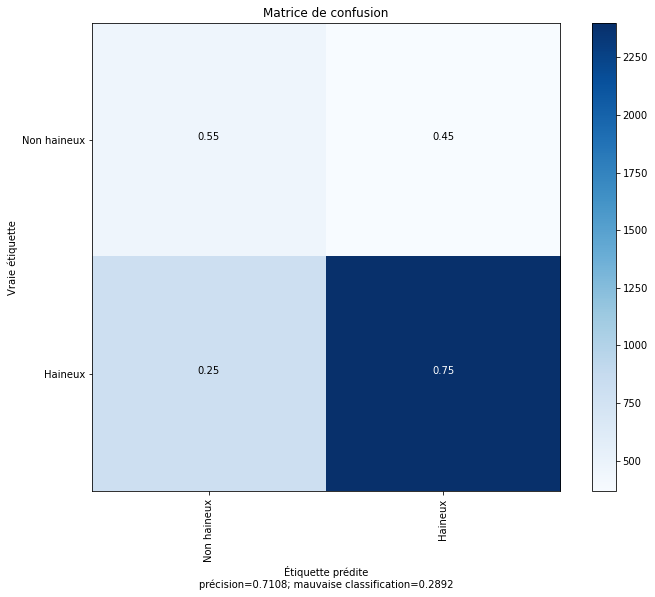

In [22]:
plot_confusion_matrix(val_labels, cat_val_pred.cpu(), ['Non haineux', 'Haineux'])

In [43]:
start = 20 
n = 10
for msg, lab in zip(val_tweets[start:start+n], cat_val_pred[start:start+n]):
    slab = "haineux" if lab == 1 else "normal"
    print("{} :\t{}".format(slab, msg))

haineux :	@user quel mongol ils n'ont qu'à pas donner des salaires monstrueux au moindre joueur de merde qui vient
haineux :	@user @user @user arrete de t'enerver t'es pas crédible dirait un gros con de gamin attardé je voi… @url
haineux :	irl une gauchiste bobo anti-raciste : « quand je lis @user ou @user de part leurs provocations i… @url
haineux :	@user t’a vu gl dirait un attardé...
normal :	forum islam: au nom de la lutte contre le séparatisme et le terrorisme l'etat chinois entreprend la désislamisati… @url
haineux :	@user @user @user donne toujours le sale boulot à l arabe de service et ces énergumènes se sentent intégrés
haineux :	@user les renois c'est les premiers à tailler les rebeus mais quand nous les tacle pour rigoler ils sorten… @url
haineux :	@user tu te crois intelligent avec ta réflexion facebook d'attardé ?
haineux :	rt @user c'est con un gauchiste quand meme !!! @url
haineux :	shoutout les daronnes rebeus avec leurs fils adorés @url


In [6]:
tokenizer = CamembertTokenizer.from_pretrained("models/tweetbert", do_lowercase=False)
classifier = CamembertForSequenceClassification.from_pretrained("models/final_8020only_eq6448norm1M")

In [46]:
r = classifier.to('cuda:0')

In [45]:
def predict(phrase):
    enc = tokenizer(phrase, padding=True, truncation=True, max_length=512, return_tensors='pt')
    enc.to('cuda:0')
    with torch.no_grad():
        outp = classifier(**enc)
    pred = torch.nn.functional.softmax(outp.logits, dim=1)
    plabels = torch.argmax(pred, dim=1)
    return "haineux" if plabels[0] == 1 else "normal"

In [50]:
def predict_per(phrase):
    enc = tokenizer(phrase, padding=True, truncation=True, max_length=512, return_tensors='pt')
    enc.to('cuda:0')
    with torch.no_grad():
        outp = classifier(**enc)
    pred = torch.nn.functional.softmax(outp.logits, dim=1)
    return pred

In [48]:
predict("J'aime la pizza quatre fromages.")

'normal'

In [47]:
predict("Je déteste les arabes.")

'haineux'

In [44]:
predict_per("J'ai eu beaucoup de chance")

tensor([[0.9958, 0.0042]])

In [60]:
with open("clusters/bert_clusters_africain/africain_bertsom49/africain_bertsom49_cluster_12_raw_msg.txt", "r") as f:
    test_lines = f.read().splitlines()

In [61]:
for msg in test_lines:
    print("{} : {}".format(predict(msg), msg))

haineux : Momo au match retour fais nous plaisir ARRETE DE TWITTER à chaque fois quand tu le fais le REAL encaisse sale chat noir
haineux : Ancelotti nous insultes de sale noir là je vois pas d’autre explication désoler
haineux : Putin mendy est trop nul va te faire enculer sale noir
haineux : MAHREZ SALE NOIR
haineux : Ptdrrrr mais il est très bon à la relance frere traite le de sale noir vas y
haineux : Meme lui il est étonné du sale qu’il a fait sur Or Noir mdr
normal : Nan il ce fait washer tt le match peine perdu je l’es regarder
haineux : La defense mdrrr des gens pensent que l’autre babouin brésilien va pas s’amuser
haineux : Tous les fils de sous race inférieur que sont les pros cr7 foot savent ça a la limite
haineux : Vas te faire foutre connard, espèce de cancre.
haineux : Mais sah le Bayern comment il on pu se faire sortir par cette équipe de babouin ? C'est du Cholismo low cost
haineux : Un supporte corse raciste noir insulte mendy de sale noir
haineux : Mais sale negre de 

### Extraire 6448 messages non haineux du premier jeu de données

In [38]:
labels_1M = np.load("datasets/MillionTweets_NEFU_labels.npy")

In [39]:
len(dataset_1M)

658009

In [40]:
labels_1M.shape

(658009,)

In [41]:
join_1M = [(msg, lab) for (msg, lab) in zip(dataset_1M, labels_1M)]

In [53]:
random.Random(0).shuffle(join_1M)

In [43]:
with open("kw_hate.txt", 'r') as f:
    hate_kw = f.read().splitlines()

On considère un message comme non haineux s'il ne contient pas de mot-clé haineux et s'il n'a pas été détecté comme haineux par le modèle de validation

In [54]:
n_max = 6448
n_norm = 0
norm_msg = []

i = 0
while (n_norm < n_max):
    msg, lab = join_1M[i]
    if (lab == 0 and not any(kw in msg for kw in hate_kw)):
        n_norm +=1
        norm_msg.append(msg)
    i += 1

In [56]:
with open("clusters/bert_clusters49_post_IF/norm_msg_eq_6448", 'w') as f:
    for msg in norm_msg:
        f.write("{}\n".format(msg))